In [1]:
import intake
from easygems import healpix as egh

import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

from scipy.stats import skew

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

cmap = 'Blues_r' # for plotting
plot_path = "outputs/"

In [2]:
# Time period

time = ('2020-08-01','2020-08-31')

# Region

domains10x10 = {
    "peruvian":     np.array([-90, -80, -20, -10]) ,
    "namibian":     np.array([0, 10, -20, -10]),
    "californian":  np.array([-130, -120, 20, 30]),
    "canarian":     np.array([-35, -25, 15, 25])
}

map_domain = domains10x10['namibian'] + np.array([-1,1,-1,1])

In [3]:
# Load dataset

hknode = 'EU'
sim = 'icon_d3hp003'
zoom = 11


cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[hknode]

ds = cat[sim](time_method='inst',time='PT6H',zoom=zoom).to_dask().pipe(egh.attach_coords)

In [4]:
# Select time period and and region

cells = egh.isel_extent(ds,map_domain)

ds = ds.sel(time=slice(*time)).isel(cell=cells)

In [5]:
%%time

# Integrate a 3D variable in vertical

ds['qallvi'] = (ds['qall'].integrate('pressure')/9.81) \
    .assign_attrs(long_name='Total condensate', units='kg/m^2')

CPU times: user 13 s, sys: 6.8 s, total: 19.8 s
Wall time: 42.3 s


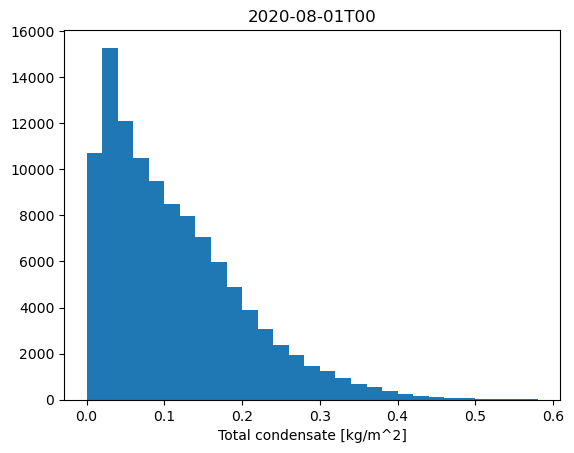

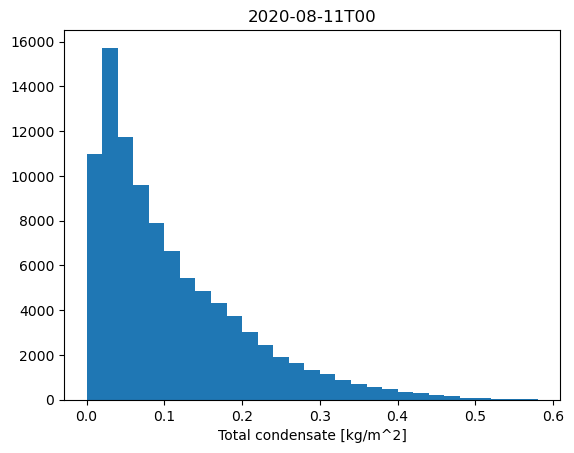

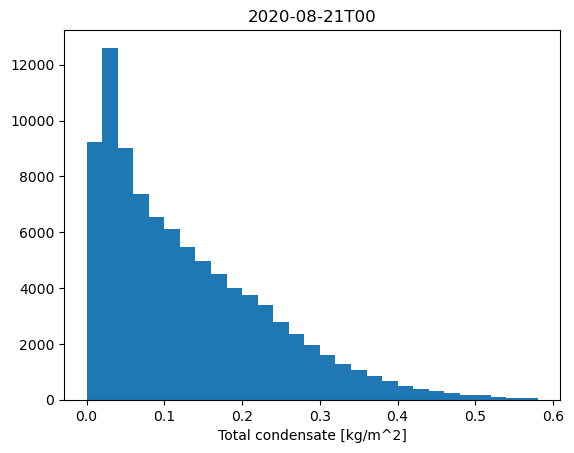

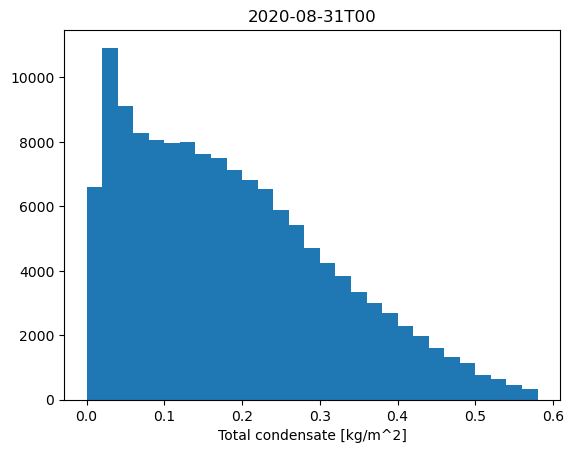

In [6]:
# Plotting distributions of total condensate a column

time_step = np.timedelta64(10,'D') # every 10 days
time_list = np.arange(ds.time[0].values,ds.time[-1].values,time_step)
for t in time_list:
    data = ds['qallvi'].sel(time=t)
    data = data.where(data > 1e-2)
    plt.hist(data, bins = np.arange(0,0.6,0.02))
    plt.xlabel('Total condensate [kg/m^2]')
    datestr = t.astype('datetime64[h]').item().strftime('%Y-%m-%dT%H')
    plt.title(datestr)
    plt.show()

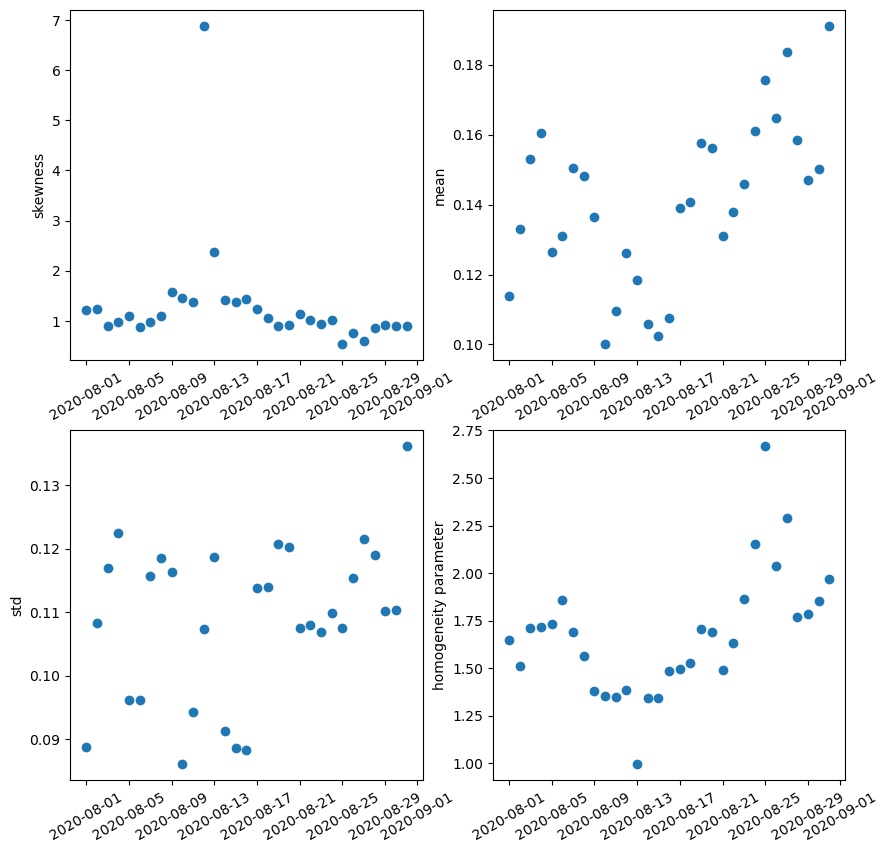

In [7]:
# Distribution parameters

skewness_list, mean_list, std_list, max_list = [], [], [], []

time_step = np.timedelta64(1,'D') # every 6 h
time_list = np.arange(ds.time[0].values,ds.time[-1].values,time_step)

for t in time_list:
    data = ds['qallvi'].sel(time=t)
    data = data.where(data > 1e-2)
    flattened_data = data.values.flatten()
    valid_data = flattened_data[~np.isnan(flattened_data)]

    if valid_data.size > 0:
        skewness_list.append(skew(valid_data))
        mean_list.append(np.mean(valid_data))
        std_list.append(np.std(valid_data))
        max_list.append(np.max(valid_data))
    else:
        skewness_list.append(np.nan) 
        mean_list.append(np.nan)
        std_list.append(np.nan)
        max_list.append(np.nan)

fig, ax = plt.subplots(2,2, figsize = (10,10))

ax[0][0].scatter(time_list, skewness_list)
ax[0][0].set_ylabel('skewness')

ax[0][1].scatter(time_list, mean_list)
ax[0][1].set_ylabel('mean')

ax[1][0].scatter(time_list, std_list)
ax[1][0].set_ylabel('std')

mean_div_by_std = (np.array(mean_list) / np.array(std_list))**2
ax[1][1].scatter(time_list, mean_div_by_std)
ax[1][1].set_ylabel('homogeneity parameter')

for row in ax:
    for axis in row:
        axis.tick_params("x", rotation=30)
plt.show()

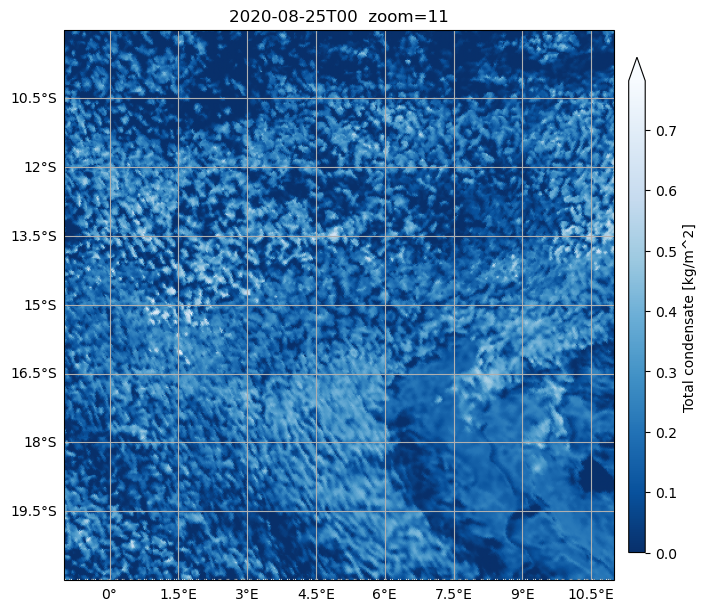

In [10]:
# Checking the snapshot for max value of homogeneity parameter
var = 'qallvi'

figsize = (8,6)
t = time_list[np.argmax(mean_div_by_std)]

fig, ax = plt.subplots(figsize=figsize,
                        subplot_kw={"projection": ccrs.PlateCarree()},
                        constrained_layout=True)

ax.set_extent(map_domain, crs=ccrs.PlateCarree())

im = egh.healpix_show(ds[var].sel(time=t), ax=ax, cmap=cmap)

ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '10m'),
               facecolor='none', edgecolor='red', linewidth=1)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

cb = plt.colorbar(im, ax=ax, shrink=0.9, aspect=30, pad=0.02, extend='max',
                  label=f"{ds[var].attrs['long_name']:s} [{ds[var].attrs['units']:s}]")

datestr = t.astype('datetime64[h]').item().strftime('%Y-%m-%dT%H')
ax.set_title(datestr+f"  zoom={zoom:d}")

plt.savefig(plot_path+var+'_'+datestr+'max_homogeneity',bbox_inches='tight',dpi=300)
#plt.close(fig) # Uncomment if you don't want to see the plots in jupyter but only save to files

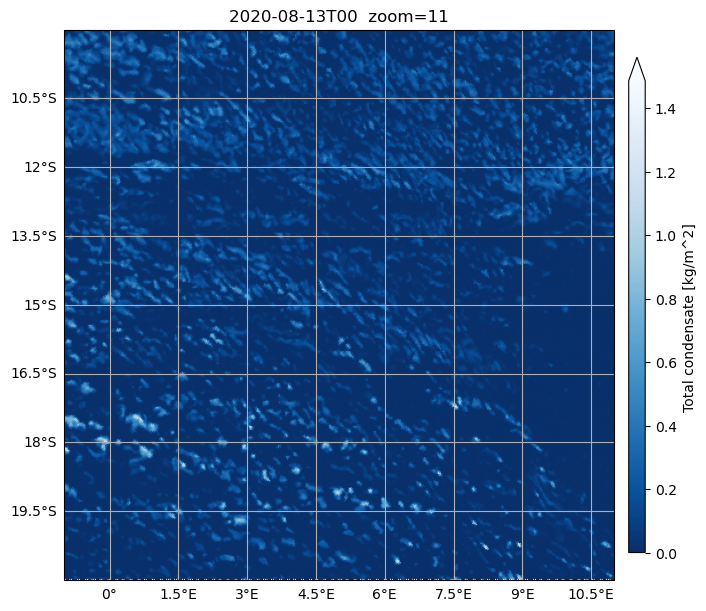

In [11]:
# Checking the snapshot for min value of homogeneity parameter
var = 'qallvi'
figsize = (8,6)
t = time_list[np.argmin(mean_div_by_std)]

fig, ax = plt.subplots(figsize=figsize,
                        subplot_kw={"projection": ccrs.PlateCarree()},
                        constrained_layout=True)

ax.set_extent(map_domain, crs=ccrs.PlateCarree())

im = egh.healpix_show(ds[var].sel(time=t), ax=ax, cmap=cmap)

ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '10m'),
               facecolor='none', edgecolor='red', linewidth=1)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

cb = plt.colorbar(im, ax=ax, shrink=0.9, aspect=30, pad=0.02, extend='max',
                  label=f"{ds[var].attrs['long_name']:s} [{ds[var].attrs['units']:s}]")

datestr = t.astype('datetime64[h]').item().strftime('%Y-%m-%dT%H')
ax.set_title(datestr+f"  zoom={zoom:d}")

plt.savefig(plot_path+var+'_'+datestr+'max_homogeneity',bbox_inches='tight',dpi=300)
#plt.close(fig) # Uncomment if you don't want to see the plots in jupyter but only save to files

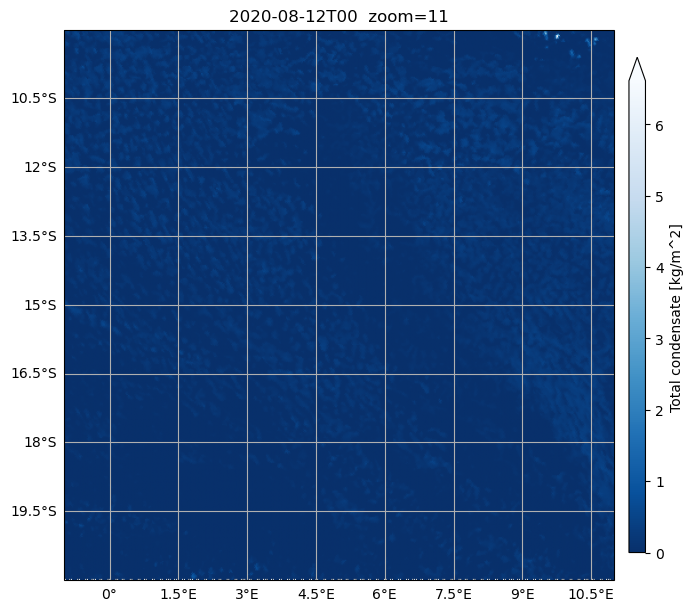

In [12]:
# Checking where does the high skewness on 12 August come from
var = 'qallvi'
figsize = (8,6)
t = time_list[np.argmax(skewness_list)]

small_domain = np.array([9, 11, -10, -8])

fig, ax = plt.subplots(figsize=figsize,
                        subplot_kw={"projection": ccrs.PlateCarree()},
                        constrained_layout=True)

ax.set_extent(map_domain, crs=ccrs.PlateCarree())

maxval = np.max(ds[var].sel(time=t)).item()
im = egh.healpix_show(ds[var].sel(time=t), ax=ax, cmap=cmap, vmin=0, vmax=maxval)

ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '10m'),
               facecolor='none', edgecolor='red', linewidth=1)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

cb = plt.colorbar(im, ax=ax, shrink=0.9, aspect=30, pad=0.02, extend='max',
                  label=f"{ds[var].attrs['long_name']:s} [{ds[var].attrs['units']:s}]")

datestr = t.astype('datetime64[h]').item().strftime('%Y-%m-%dT%H')
ax.set_title(datestr+f"  zoom={zoom:d}")

plt.savefig(plot_path+var+'_'+datestr,bbox_inches='tight',dpi=300)

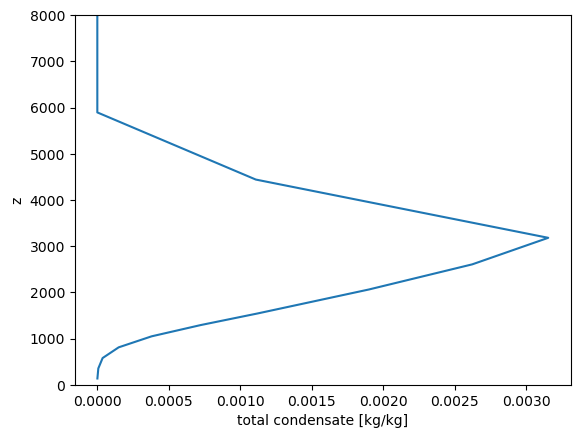

In [13]:
# There's a deep cloud at ~ 9 S, 10 E
# Plotting the profile of condensate:

t = time_list[np.argmax(skewness_list)]
ipix_max = ds['qallvi'].sel(time=t).argmax(dim='cell').item()
profile = ds['qall'].isel(cell=ipix_max).sel(time=t)
plt.plot(profile, ds['zg'].isel(cell=ipix_max).sel(time=t))
plt.xlabel('total condensate [kg/kg]')
plt.ylabel('z')
plt.ylim(0,8000)
plt.show()